# This example demonstrates the prediction of the detail views of cars on a website from the information contained in the other columns of the data 'Items_Cars_Data.csv'. 
# The file 'Data_description.csv' describes the columns.

# The notebook was created by Randa Natras: randa.natras@thotmail.com 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

# **Load data**

The data will be loaded into a pandas DataFrame, which are good tools for manipulating and displaying the data. Date columns are converted to datetime.

In [ ]:
df = pd.read_csv ('Items_Cars_Data.csv', delimiter=';', parse_dates=["created_date", 'deleted_date'], dayfirst=True)

In [ ]:
description = pd.read_csv ('Data_Description.csv', delimiter=';')

In [ ]:
description

,column name,description
0,article_id,unique article identifier
1,product_tier,premium status of the article
2,make_name,name of the car manufacturer
3,price,price of the article
4,first_zip_digit,first digit of the zip code of the region the ...
5,first_registration_year,year of the first registration of the article
6,created_date,creation date of the listing
7,deleted_date,deletion date of the listing
8,search_views,number of times the article has been shown as ...
9,detail_views,number of times the article has been clicked on


# **Examine data**

It's good practice to check the data first to get better understanding of data.

In [ ]:
df

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,2018-07-24,2018-08-24,3091.0,123.0,30,0.0378033
1,354412280,Basic,Mercedes-Benz,35950,4,2015,2018-08-16,2018-10-07,3283.0,223.0,52,0.067925678
2,349572992,Basic,Mercedes-Benz,11950,3,1998,2018-07-16,2018-09-05,3247.0,265.0,51,0.081613797
3,350266763,Basic,Ford,1750,6,2003,2018-07-20,2018-10-29,1856.0,26.0,101,0.014008621
4,355688985,Basic,Mercedes-Benz,26500,3,2014,2018-08-28,2018-09-08,490.0,20.0,12,0.040816327
...,...,...,...,...,...,...,...,...,...,...,...,...
78265,364276155,Basic,BMW,7950,4,2005,2018-11-24,2019-01-31,5254.0,251.0,68,0.047773125
78266,354422963,Basic,Citroen,5425,1,2012,2018-08-16,2018-08-31,330.0,27.0,15,0.081818182
78267,361201591,Premium,Mazda,1444,5,2005,2018-10-20,2018-10-27,10731.0,495.0,8,0.04612804
78268,353637799,Basic,Fiat,7840,5,2014,2018-08-08,2018-12-12,1106.0,8.0,126,0.007233273


In [ ]:
#Check the data type of each column
df.dtypes

article_id                          int64
product_tier                       object
make_name                          object
price                               int64
first_zip_digit                     int64
first_registration_year             int64
created_date               datetime64[ns]
deleted_date               datetime64[ns]
search_views                      float64
detail_views                      float64
stock_days                          int64
ctr                                object
dtype: object

In [ ]:
# See the column data types and non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78270 entries, 0 to 78269
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   article_id               78270 non-null  int64         
 1   product_tier             78270 non-null  object        
 2   make_name                78270 non-null  object        
 3   price                    78270 non-null  int64         
 4   first_zip_digit          78270 non-null  int64         
 5   first_registration_year  78270 non-null  int64         
 6   created_date             78270 non-null  datetime64[ns]
 7   deleted_date             78270 non-null  datetime64[ns]
 8   search_views             78260 non-null  float64       
 9   detail_views             78260 non-null  float64       
 10  stock_days               78270 non-null  int64         
 11  ctr                      78246 non-null  object        
dtypes: datetime64[ns](2), float64(2)

From the first data check, the data frame has 11 columns and 38862 rows.
The object columns include a total of 3 columns, of which two columns represent product_tier and make_name, and third one ctr was calculated from two numeric columns, as described in the file "Data_Description.csv". 
Total numerical (int64 and float64) columns are 7, and two columns are datetime64 type.

In [ ]:
#check if there are missing values
df.isna().sum()

article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64

 Columns 'search_views', 'detail_views', and 'ctr' contain missing values. The missing data need to be handle as many machine learning algorithms do not support missing values. Let's first check where the missing values are.

In [ ]:
np.where(df['search_views'].isnull() == True)[0]

array([10151, 21423, 27830, 47864, 57347, 60752, 63571, 65121, 66492,
       72388])

In [ ]:
np.where(df['detail_views'].isnull() == True)[0]

array([10151, 21423, 27830, 47864, 57347, 60752, 63571, 65121, 66492,
       72388])

In [ ]:
np.where(df['ctr'].isnull() == True)[0]

array([ 6738, 10151, 19983, 21423, 26122, 27830, 28823, 38923, 43222,
       47864, 52285, 57347, 60752, 63571, 65121, 66492, 68578, 69156,
       70752, 71063, 71834, 72388, 72600, 78029])

There are 10 missing values in search_views and detail_view at the same locations, and 24 missing values in ctr, 10 of which overlap with the location of the missing values in the previously mentioned columns, i.e. locations [10151, 21423, 27830, 47864, 57347, 60752, 63571, 65121, 66492, 72388]. Let's now check the first 10 rows with the missing values in 'ctr'.

In [ ]:
display(df[6738:6739])
display(df[10151:10152])
display(df[19983:19984])
display(df[21423:21424])
display(df[26122:26123])
display(df[27830:27831])
display(df[28823:28824])
display(df[38923:38924])
display(df[43222:43223])
display(df[47864:47865])

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
6738,355684985,Basic,Volvo,5950,8,2009,2018-08-28,2018-08-28,0.0,0.0,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
10151,363161664,Basic,Renault,4950,3,2011,2018-11-12,2019-03-01,NaN,NaN,109,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
19983,360460901,Basic,Mercedes-Benz,105,7,2004,2018-10-12,2018-10-12,0.0,0.0,-1,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
21423,358837372,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
26122,360460897,Basic,Mercedes-Benz,22445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
27830,358837359,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
28823,360460890,Basic,Mercedes-Benz,26445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
38923,360471136,Basic,Audi,1500,2,2012,2018-10-12,2018-10-12,0.0,0.0,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
43222,360493605,Basic,Mercedes-Benz,37500,3,2002,2018-10-12,2018-10-12,0.0,0.0,0,NaN


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
47864,358837344,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN


There is clearly overlap of missing values for all 3 columns (search_views, detail_views, ctr), but ctr column has extra number of missing values. Due to the overlap of missing values in search_views and detail_views with ctr, or 0 values in search_views and detail_views, we cannot use search_views and detail_views to impute ctr here, or vice versa. Some rows have 0 search_views and 0 detail_views, where the stock days are 0 or negative. This may mean that the article was deleted shortly after it was created. I assume that these rows are not so important and meaningful for prediction, since the article was quickly deleted without being viewed, and there are only a few such cases. 

Imputing values for search_views and detail_views is a bit challenging, as they depend on the number of users, searches and clicks. Therefore, imputation using methods such as forward or backward filling is not suitable here. Another approach could be to group the data based on other columns where unique links to the number of views can be found. Then we could group the data by that characteristic/feature and calculate the mean or median value of the views in that group to impute the missing values. Let us first see if this approach is practical for this problem case. 

In [ ]:
df.groupby('stock_days')['detail_views'].value_counts()

stock_days  detail_views
-3          0.0             2
            2.0             1
            5.0             1
-2          1.0             1
            3.0             1
                           ..
 127        89.0            1
            142.0           1
            185.0           1
            246.0           1
            898.0           1
Name: detail_views, Length: 24484, dtype: int64

In [ ]:
df.groupby('stock_days')['search_views'].value_counts()

stock_days  search_views
-3          17.0            1
            24.0            1
            43.0            1
            143.0           1
-2          10.0            1
                           ..
 127        2308.0          1
            3099.0          1
            4792.0          1
            5540.0          1
            27923.0         1
Name: search_views, Length: 59283, dtype: int64

There are large differences between one group of stock days, for example 127 stock days have detail_views ranging from 89 to 898. The situation is similar with search_views.

In [ ]:
df.groupby(['price'])['search_views'].value_counts()

price   search_views
50      23.0            1
        55.0            1
        125.0           1
        172.0           1
        270.0           1
                       ..
239500  6928.0          1
        23844.0         1
239800  20950.0         1
248341  19785.0         1
249888  3842.0          1
Name: search_views, Length: 75444, dtype: int64

Grouping by price shows that search_views for the same price vary widely and that search_views are not clearly dependent on price.

We can also group it by multiple columns.

In [ ]:
df.groupby(['stock_days', 'price'])['detail_views'].value_counts()

stock_days  price  detail_views
-3          950    0.0             1
            11995  0.0             1
            13950  5.0             1
            24850  2.0             1
-2          3850   12.0            1
                                  ..
 127        15450  185.0           1
            17890  246.0           1
            42444  898.0           1
            46895  24.0            1
            47880  89.0            1
Name: detail_views, Length: 76138, dtype: int64

In [ ]:
df.groupby(['product_tier','stock_days','search_views'])['detail_views'].value_counts()

product_tier  stock_days  search_views  detail_views
Basic         -3          17.0          2.0             1
                          24.0          0.0             1
                          43.0          0.0             1
                          143.0         5.0             1
              -2          10.0          1.0             1
                                                       ..
Premium        124        24234.0       1026.0          1
                          40181.0       1981.0          1
                          92679.0       1836.0          1
               125        2044.0        110.0           1
                          29520.0       619.0           1
Name: detail_views, Length: 75826, dtype: int64

Based on grouping it is difficult to clearly detect groups which could be used for imputing approximate values for views columns.

Another possible approach could be to try to predict these values using the other columns/features. However, those predicted values would be only a proxy for the true values. 

The dataset has in total 78270 rows. Deleting 24 rows should not have much affect to the result comparing to the length of the complete dataset. Therefore, the rows with missing values will be removed in the next step.

In [ ]:
#deleting rows with missing values
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.isna().sum()

article_id                 0
product_tier               0
make_name                  0
price                      0
first_zip_digit            0
first_registration_year    0
created_date               0
deleted_date               0
search_views               0
detail_views               0
stock_days                 0
ctr                        0
dtype: int64

Moreover, when checking the data, the error value in ctr is found in the row 849. Therefore it is better to recalculate the column.

In [ ]:
#27.624.309.392.265.100 is error value, it should be 0.27624309392265100 
df[849:850]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
849,361161145,Basic,Volkswagen,32450,6,2018,2018-10-20,2018-11-08,2172.0,60.0,19,27.624.309.392.265.100


In [ ]:
#because of the problems with values, I will re-calculate again 'ctr' column as the quotient of detail_views over search_views
df['ctr']=df['detail_views'] / df['search_views']

In [ ]:
df

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,2018-07-24,2018-08-24,3091.0,123.0,30,0.039793
1,354412280,Basic,Mercedes-Benz,35950,4,2015,2018-08-16,2018-10-07,3283.0,223.0,52,0.067926
2,349572992,Basic,Mercedes-Benz,11950,3,1998,2018-07-16,2018-09-05,3247.0,265.0,51,0.081614
3,350266763,Basic,Ford,1750,6,2003,2018-07-20,2018-10-29,1856.0,26.0,101,0.014009
4,355688985,Basic,Mercedes-Benz,26500,3,2014,2018-08-28,2018-09-08,490.0,20.0,12,0.040816
...,...,...,...,...,...,...,...,...,...,...,...,...
78241,364276155,Basic,BMW,7950,4,2005,2018-11-24,2019-01-31,5254.0,251.0,68,0.047773
78242,354422963,Basic,Citroen,5425,1,2012,2018-08-16,2018-08-31,330.0,27.0,15,0.081818
78243,361201591,Premium,Mazda,1444,5,2005,2018-10-20,2018-10-27,10731.0,495.0,8,0.046128
78244,353637799,Basic,Fiat,7840,5,2014,2018-08-08,2018-12-12,1106.0,8.0,126,0.007233


Looking at previous df table it can be noticed that some values are slightly different in ctr column, e.g. row 1, 78291, 78294. So it was good to recalculate the ctr column.

# **Deriving new features**

We can create new feature from time information, for example, to analyze seasonality. A simple search on the Internet shows that the peak season for car purchases is in spring (from March to the end of May) and in fall (from September to November). Then we could expect higher search_views and detail_views in spring and fall. So let's create a new function that contains information about whether a car is offered in one of these two seasons.

In [ ]:
#extract months
df['created_month'] = pd.DatetimeIndex(df['created_date']).month
df['deleted_month'] = pd.DatetimeIndex(df['deleted_date']).month

In [ ]:
#Spring: from March through the end of May, and Fall: from September through November
spring_fall= ((df['created_month'] > 2) & (df['created_month'] < 6)) | ((df['deleted_month'] > 2) & (df['deleted_month'] < 6)) | ((df['created_month'] > 8) & (df['created_month'] < 12)) | ((df['deleted_month'] > 8) & (df['deleted_month'] < 12))
df_peak_season = df.loc[spring_fall]

If a car is listed, the peak_season feature  has the value 1, if it is not listed, it has the value 0.

In [ ]:
df_peak_season['peak_season']=1
df['peak_season'] = df_peak_season['peak_season']
df['peak_season'] = df['peak_season'].fillna(0)

In [ ]:
df

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,created_month,deleted_month,peak_season
0,350625839,0,62,16750,5,2013,2018-07-24,2018-08-24,3091.0,123.0,30,0.039793,7,8,0.0
1,354412280,0,60,35950,4,2015,2018-08-16,2018-10-07,3283.0,223.0,52,0.067926,8,10,1.0
2,349572992,0,60,11950,3,1998,2018-07-16,2018-09-05,3247.0,265.0,51,0.081614,7,9,1.0
3,350266763,0,33,1750,6,2003,2018-07-20,2018-10-29,1856.0,26.0,101,0.014009,7,10,1.0
4,355688985,0,60,26500,3,2014,2018-08-28,2018-09-08,490.0,20.0,12,0.040816,8,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78240,364276155,0,10,7950,4,2005,2018-11-24,2019-01-31,5254.0,251.0,68,0.047773,11,1,1.0
78241,354422963,0,19,5425,1,2012,2018-08-16,2018-08-31,330.0,27.0,15,0.081818,8,8,0.0
78242,361201591,2,58,1444,5,2005,2018-10-20,2018-10-27,10731.0,495.0,8,0.046128,10,10,1.0
78243,353637799,0,32,7840,5,2014,2018-08-08,2018-12-12,1106.0,8.0,126,0.007233,8,12,0.0


# **Data exploratory analysis**

Now I will perform data exploratory analysis in order to better understand the data, to discover patterns, to spot anomalies and to check assumptions with the help of statistic summary and graphical representations.

Statistical summary

In [ ]:
#Descriptive statistics
df.describe()

,article_id,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr
count,7.824600e+04,78246.000000,78246.000000,78246.000000,78246.000000,78246.000000,78246.000000,78246.000000
mean,3.574863e+08,15070.682412,4.631381,2011.090573,2298.450477,93.503527,35.999105,0.046891
std,5.076876e+06,16377.089474,2.354300,6.538797,6341.363461,228.095443,32.214741,0.038822
min,3.472324e+08,50.000000,1.000000,1924.000000,1.000000,0.000000,-3.000000,0.000000
25%,3.536387e+08,5750.000000,3.000000,2008.000000,368.000000,13.000000,10.000000,0.024261
50%,3.585479e+08,10916.500000,5.000000,2013.000000,920.000000,36.000000,25.000000,0.038237
75%,3.614817e+08,18890.000000,7.000000,2015.000000,2234.000000,94.000000,55.000000,0.058679
max,3.647040e+08,249888.000000,9.000000,2106.000000,608754.000000,13926.000000,127.000000,1.833333


Numerical data: The distribution for search_views and detail_views looks skewed as mean & median (50%) values are not close.

In [ ]:
categ = ['product_tier','make_name']

In [ ]:
df[categ].describe()

,product_tier,make_name
count,78246,78246
unique,3,91
top,Basic,Volkswagen
freq,75347,9420


Categorical data: The data in product_tier has 3 unique values with the most common value being "Basic". The data in make_name has 91 unique values with the most common value being "Volkswagen".

Let's plot column product_tier.

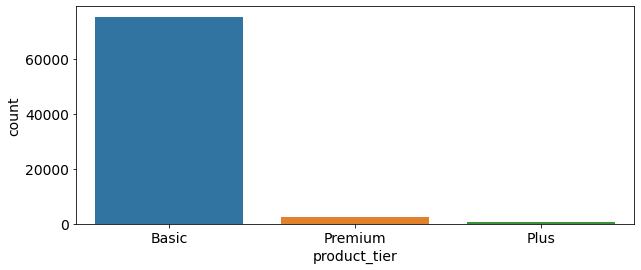

In [ ]:
sns.countplot(x="product_tier", data = df)
plt.rcParams ['figure.figsize'] =  [10,4]
plt.rcParams.update({'font.size': 14})

The majority of products are Basic Tier, while Premium and Plus Tier are in the minority.

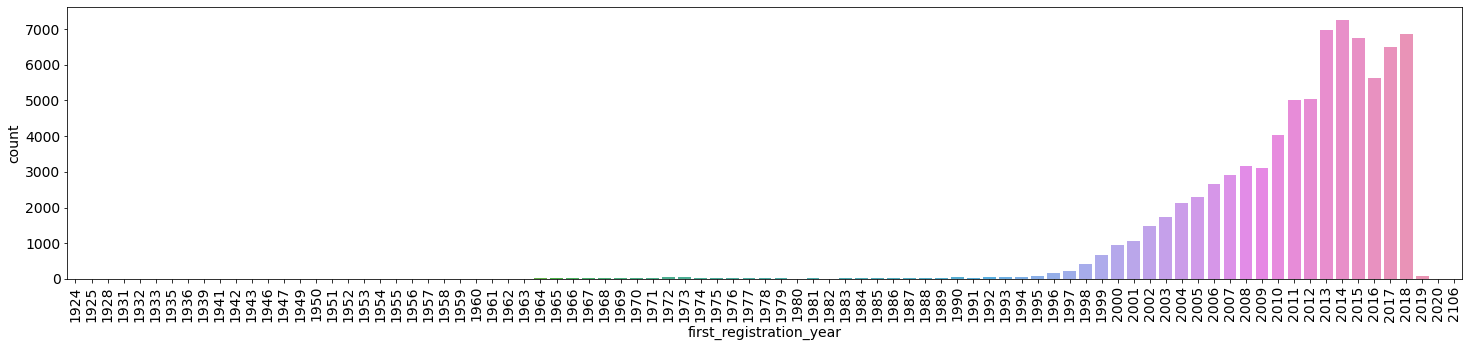

In [ ]:
sns.countplot(data = df, x="first_registration_year")
plt.xticks(rotation=90)
plt.show()

We see that the registration years are from 1924, but after 2000 we see a significant increase in the amount of data. Most items have a registration year between 2010 and 2018. Also, there is a value for first_registration_year "2106", which is an anomaly here. I suspect it should be 2016, but it might be  2006. This could be double checked to be sure what year it is. Since I cannot verify this, I will remove this row since it is only one. First I will check the problematic row.

In [ ]:
is_anomaly=(df['first_registration_year']==2106)
is_anomaly_index=df[is_anomaly].index
i=is_anomaly_index
print (i)

Int64Index([36295], dtype='int64')


In [ ]:
df[36295:36296]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,weekends_no,created_month,deleted_month,peak_season
36295,358877131,Basic,Opel,9250,7,2106,2018-09-24,2018-09-26,113.0,5.0,2,0.044248,0.0,9,9,1.0


In [ ]:
#remove row with outlier
df.drop([36295], inplace = True )
df.reset_index(drop=True, inplace=True)

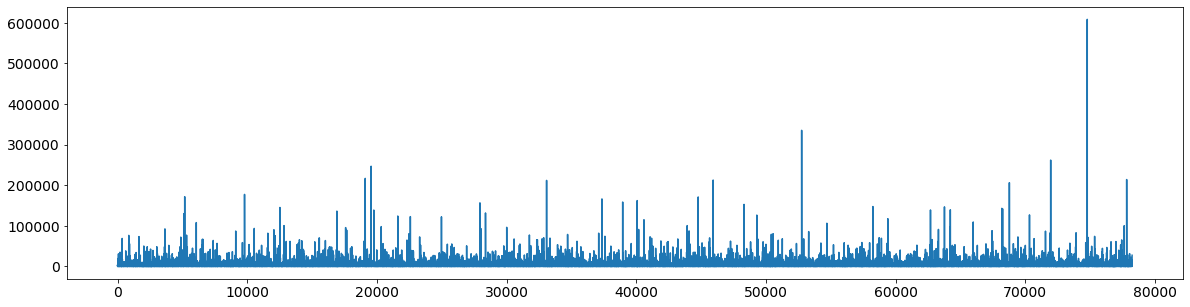

In [ ]:
plt.plot(df['search_views'])

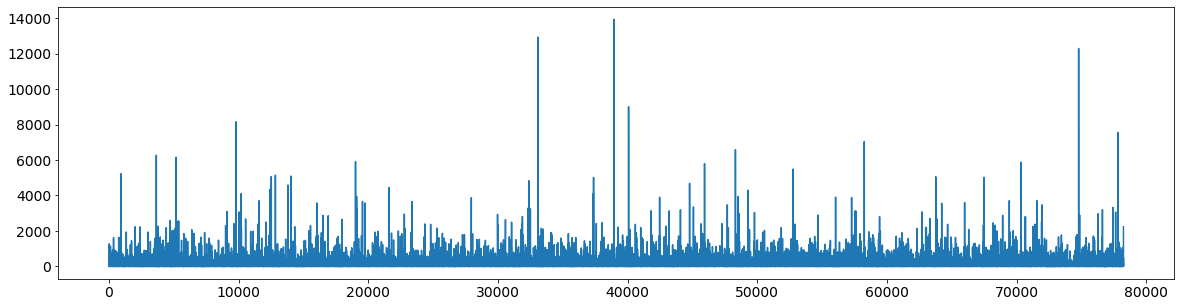

In [ ]:
plt.plot(df['detail_views'])

The graphs of search_views and detail_views show outliers (from small to very large). Some outliers observed in search_views are also seen in detail_views, suggesting that more search_views lead to more detail_views.

In [ ]:
numeric=['price', 'first_zip_digit', 'first_registration_year', 'search_views', 'detail_views', 'stock_days', 'ctr'	]

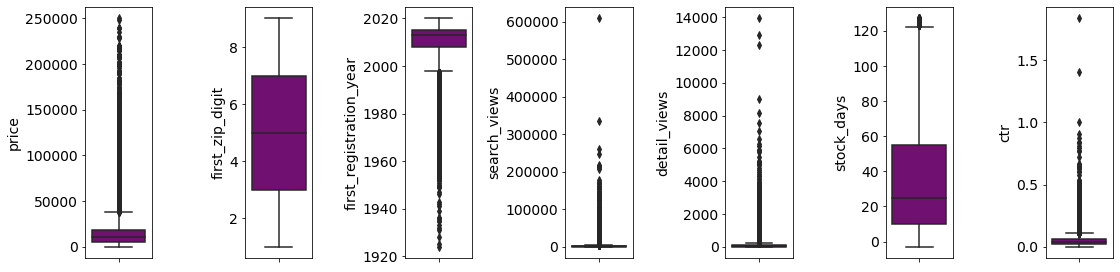

In [ ]:
features = numeric
plt.figure(figsize=(18, 4))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df[features[i]], color='purple',orient='v')
    plt.tight_layout();

In the boxplot graph can be seen that the price, first_registration_year, search_views, detail_views and ctr features have many outliers. Logarithmic (log) transformation can be used here to address skewed data effectively.

Several data columns are right skewed, except first_registration_year which is left skewed.


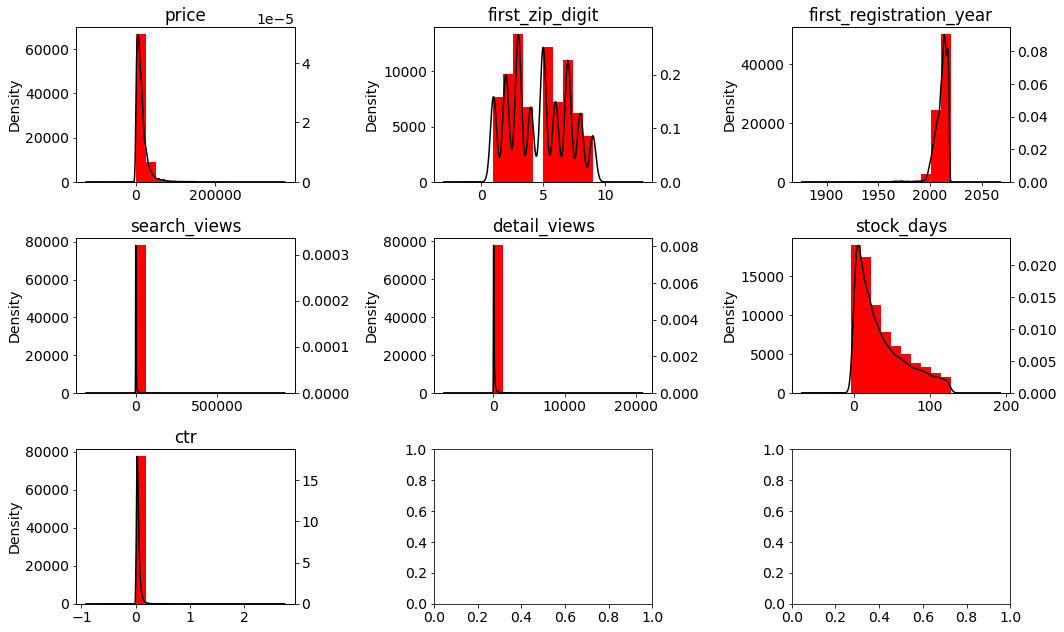

In [ ]:
#View data distribution
data_num = df[numeric]
k = len(data_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(data_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax, color='red')
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='black')
    ax2.set_ylim(0)
fig.tight_layout();

In [ ]:
#since detail_views and ctr have min values of 0, I used log(x+1) to avoid -inf values after transformation
df_log=df.copy()
df_log['price'] = np.log10(df['price']+1)
df_log['first_registration_year'] = np.log10(df['first_registration_year']+1)
df_log['search_views'] = np.log10(df['search_views']+1)
df_log['detail_views'] = np.log10(df['detail_views']+1)
df_log['ctr'] = np.log10(df['ctr']+1)

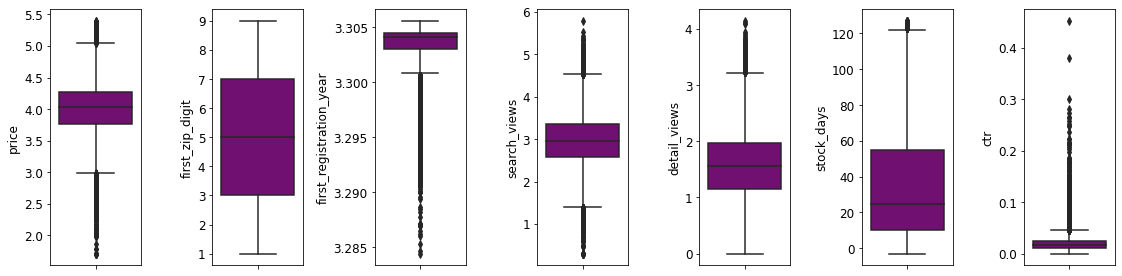

In [ ]:
#Features after logaritmic transformation
features = numeric
plt.figure(figsize=(18, 4))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df_log[features[i]], color='purple',orient='v')
    plt.tight_layout();

After log transformation, distribution of price, searc_views and detail_views corresponds better to normal distribution.

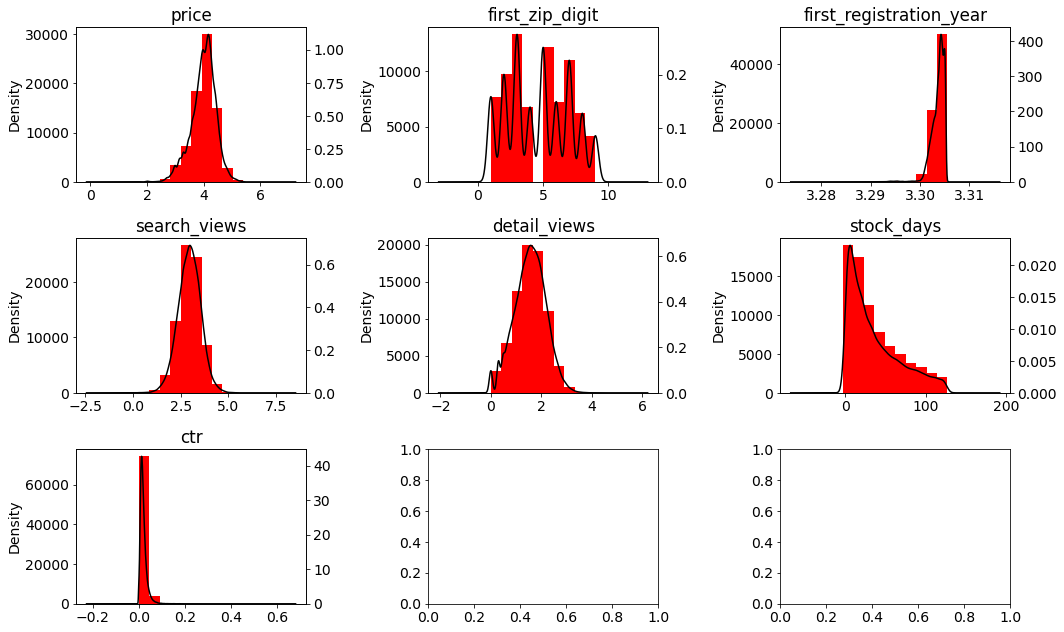

In [ ]:
#View data distribution with log transformation
data_num = df_log[numeric]
k = len(data_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(data_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax, color='red')
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='black')
    ax2.set_ylim(0)
fig.tight_layout();

<Figure size 1080x216 with 0 Axes>

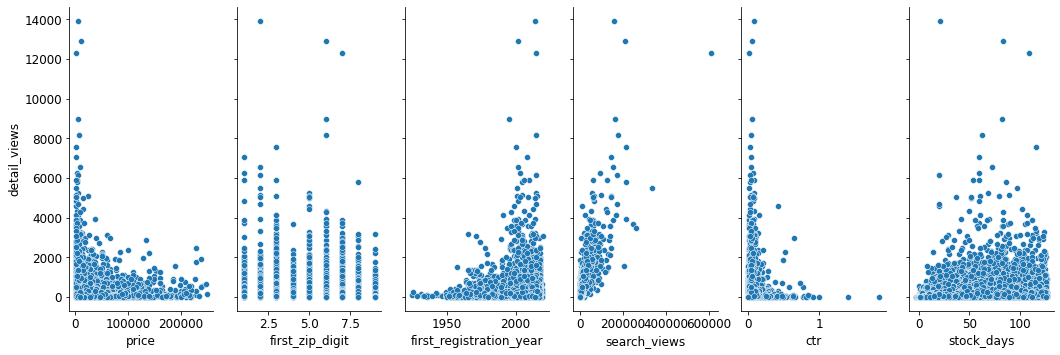

In [ ]:
#create a pairplot graph from each numeric data
plt.figure(figsize=(12,5))
sns.pairplot(data=df, 
             x_vars=['price','first_zip_digit','first_registration_year','search_views','ctr', 'stock_days'], 
             y_vars=['detail_views'], height=5, aspect=0.5);
fig.tight_layout();

From the above scatter plot, it can be seen that more detail_views have items with lower price, items offered in regions 2 and 6, and newer first_registration_years. In terms of region, the number of detail views is lowest in Region 9, which is consistent with the earlier finding that the fewest items are offered there. As the search_viewes increase, the number of detail_views also increases. There is no clear pattern for stock_days, but it can be seen that the most detail_views occur at higher values of stock_days (especially in the middle between 50 and 100 days).

The scatter plot below with logarithmic transformation of price, first_registration_year, search_views, detail_views and ctr shows a clear relationship between detail_views and search_views.

<Figure size 864x360 with 0 Axes>

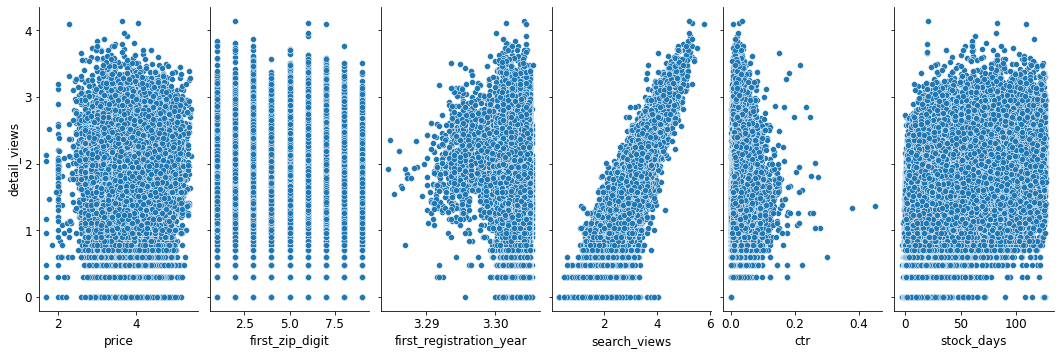

In [ ]:
#create a pairplot graph from each numeric data with log transformed features
plt.figure(figsize=(12,5))
sns.pairplot(data=df_log, 
             x_vars=['price','first_zip_digit','first_registration_year','search_views','ctr', 'stock_days'], 
             y_vars=['detail_views'], height=5, aspect=0.5);
fig.tight_layout();

In [ ]:
df_plot = df.drop(['article_id', 'make_name', 'created_date', 'deleted_date'], axis=1)

In [ ]:
df_log_plot = df_log.drop(['article_id', 'make_name', 'created_date', 'deleted_date'], axis=1)

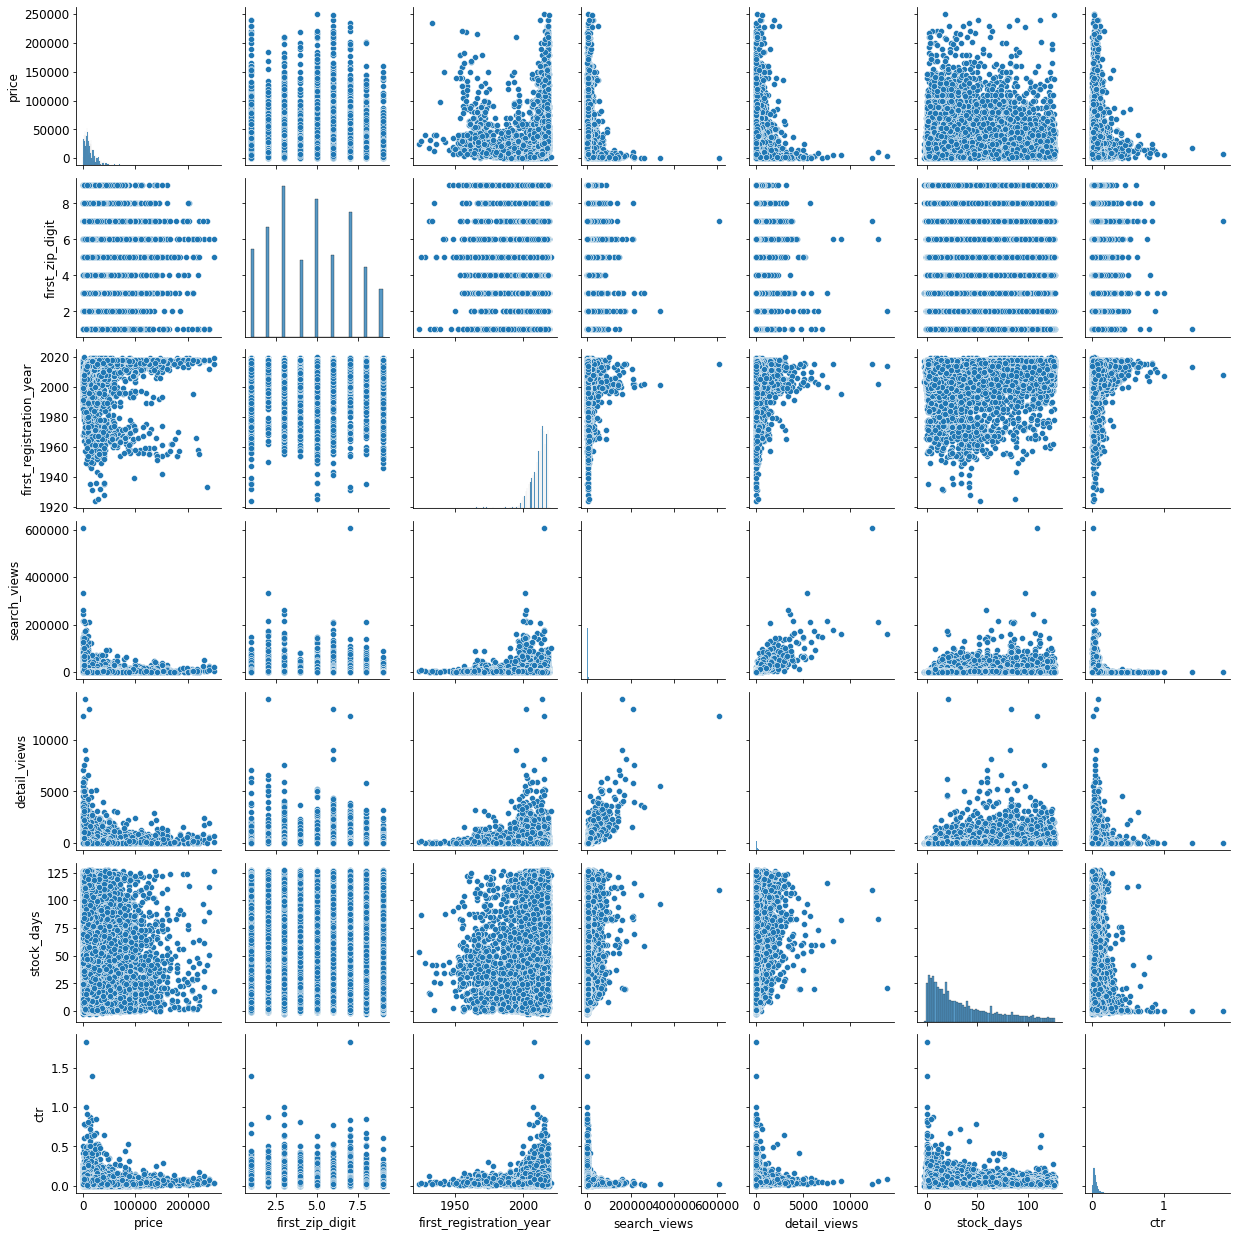

In [ ]:
sns.pairplot(df_plot)

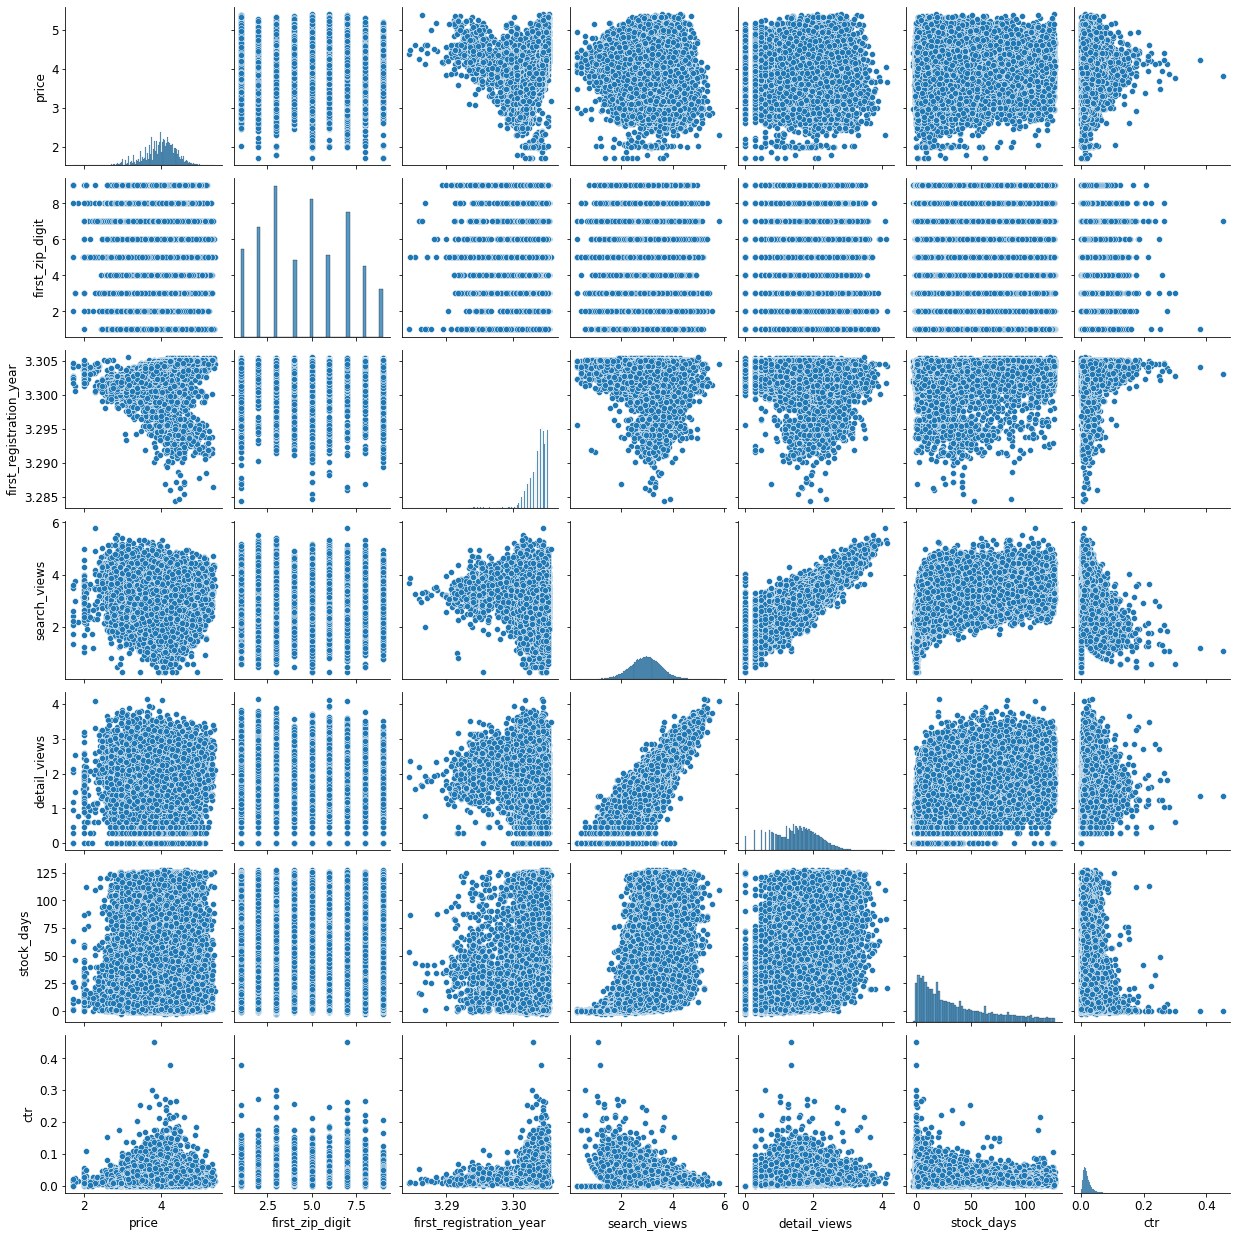

In [ ]:
sns.pairplot(df_log_plot)

Patterns between detail_views and first_zip_digit can be more clearly visible in the graph below.

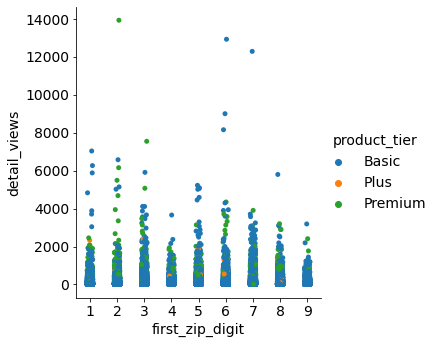

In [ ]:
sns.catplot(data=df, y='detail_views', x='first_zip_digit', hue='product_tier')

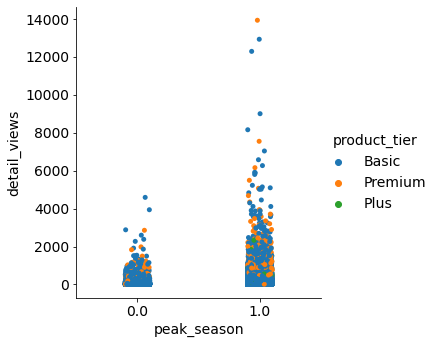

In [ ]:
sns.catplot(data=df, y='detail_views', x='peak_season',  hue='product_tier')

The graph above shows that there are more detail_views for articles listed during the peak season of car sales (spring and fall) (value 1), than for articles listed outside of the peak season (value 0), with tendency of more detailed views for Basic and Premium categories.

As the stock days on which an item is listed increases, the number of detailed views also increases. A significant increase can be observed from 20 days onwards.

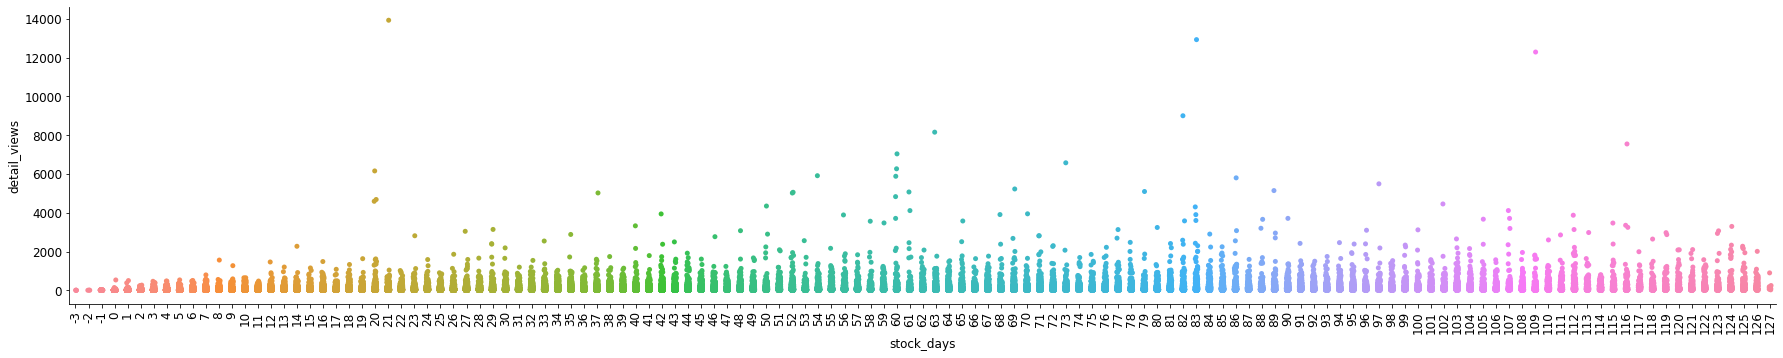

In [ ]:
sns.catplot(data=df, y='detail_views', x='stock_days', height=5, aspect=5)
plt.xticks(rotation=90)
plt.show()

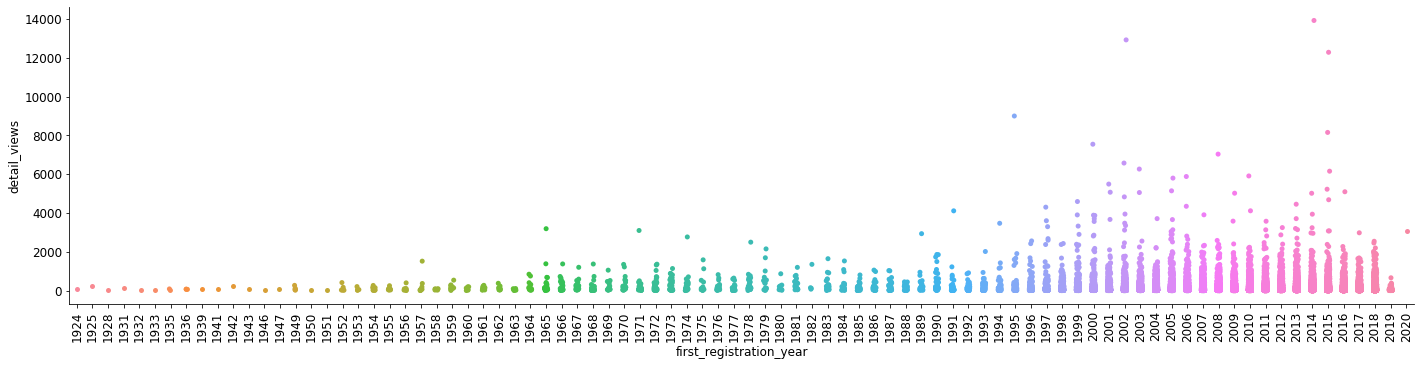

In [ ]:
sns.catplot(data=df, y='detail_views', x='first_registration_year', height=5, aspect=4)
plt.xticks(rotation=90)
plt.show()

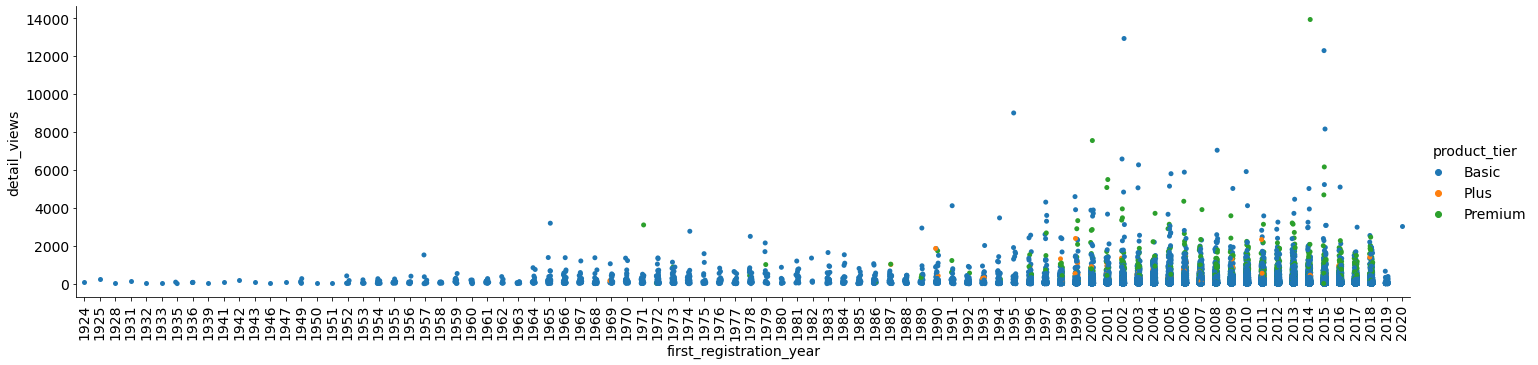

In [ ]:
sns.catplot(data=df, y='detail_views', x='first_registration_year', hue='product_tier', height=5, aspect=4)
plt.xticks(rotation=90)
plt.show()

On the graph above it can be clearly seen that more detail_views apply to articles with registration_year from 2000 with the peak in 2014 and 2015, i.e. for the cars with registration 5-6 years old (relative to the last article offered in 2020). There is a tendency for the number of detailed views to increase for the Premium tiers.

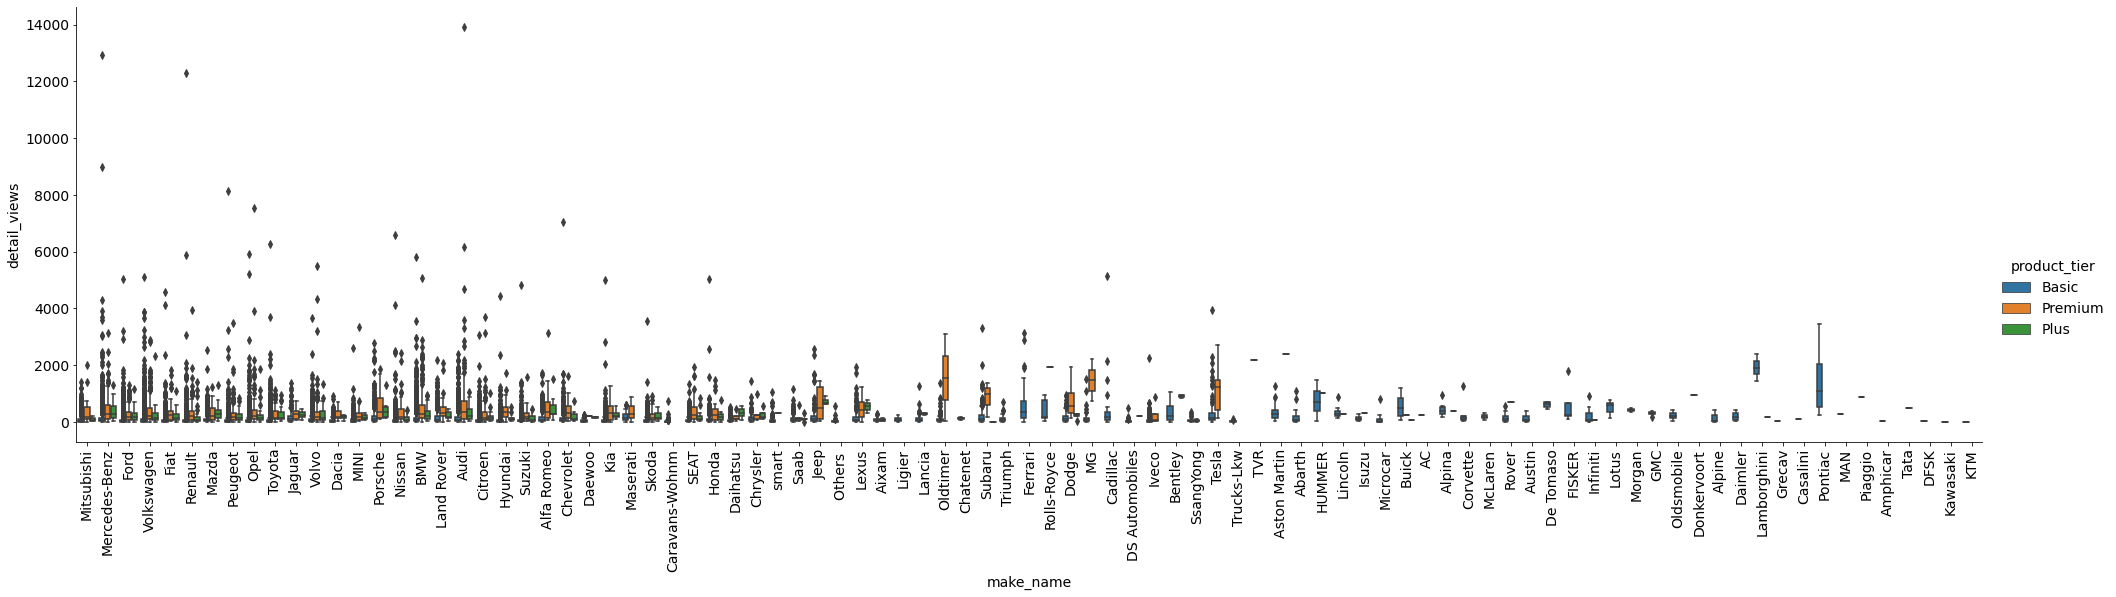

In [ ]:
sns.catplot( data = df, x='make_name', y='detail_views', hue='product_tier', kind='box', height=7, aspect=4)
plt.xticks(rotation=90)
plt.show()

On the graph above it can be seen that Premium type articles mostly have more detail_views, while Basic articles have larger outliers. This is also confirmed with the plot below, which showes larger median and maximum detail_views for the Premium and Plus articles.

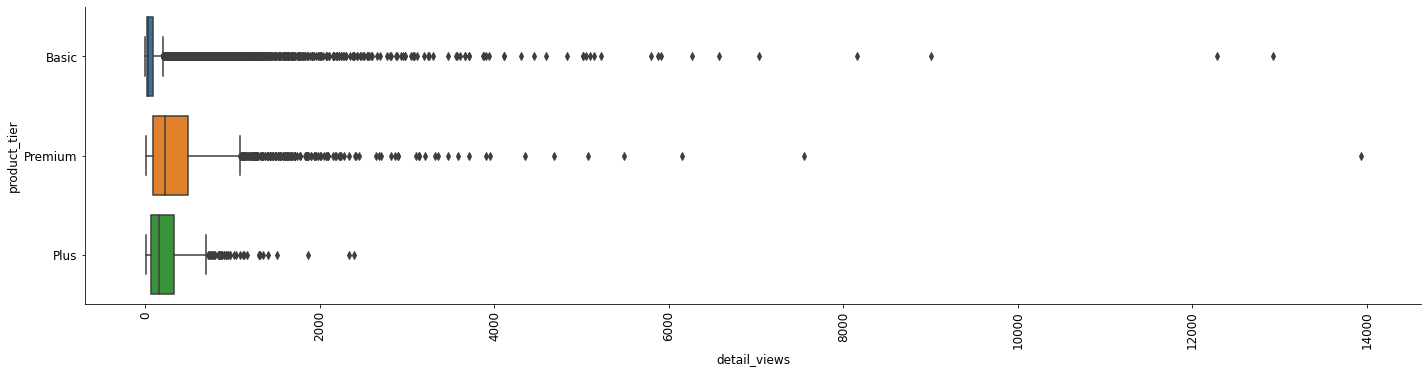

In [ ]:
sns.catplot( data = df, x='detail_views', y='product_tier', kind='box', height=5, aspect=4)
plt.xticks(rotation=90)
plt.show()

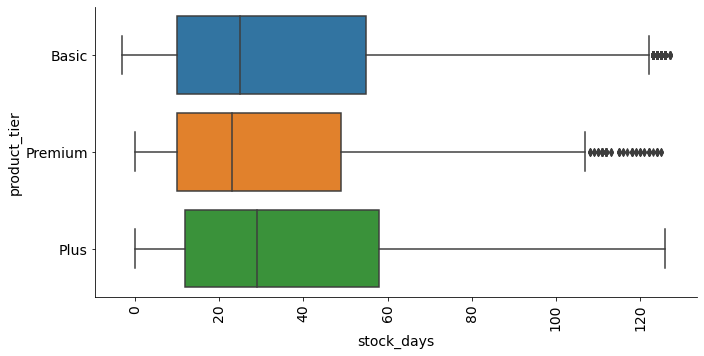

In [ ]:
sns.catplot( data = df, x='stock_days', y='product_tier', kind='box', height=5, aspect=2)
plt.xticks(rotation=90)
plt.show()

The graph above shows that the Plus articles have generally larger stock_days then the Basic articles. The median stock_days for Basic Premium is about 20 days and of about 30 stock days for Plus articles.

Based on data exploratory analysis the following conclusions can be drawn:  

1.   Most of data are skewed. Log transformation can be useful to address skewed data effectively.
2.   Product_tier: majority class is Basic, while Premium and Plus are minority classes.
3. Predicting detail_views: data analysis shows relations between the target detail_views and features such as search_views, prices, first_registration_year and some patterns in stock_days and first_zip_digit. 





# **Predicting detail views**

## **Preparing data for training**

In [ ]:
#Encoding categorical features. I chose label encoding because the number of categories in make_name is quite large and categories in product tier might be ordinal
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
label_encoder = LabelEncoder()
# Encode labels in columns 'product_tier' and 'make_name'. 
df_log['product_tier']= label_encoder.fit_transform(df_log['product_tier']) 
df_log['make_name']= label_encoder.fit_transform(df_log['make_name']) 

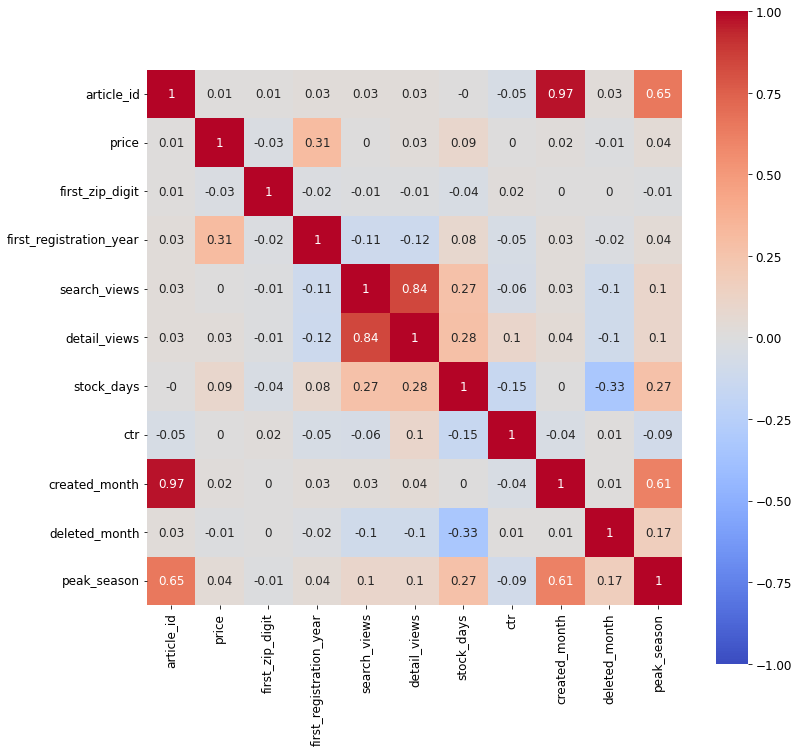

In [ ]:
c = np.round(df.corr(), 2)
plt.figure(figsize=(12,12))
sns.heatmap(c, annot=True, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.rcParams.update({'font.size':12})

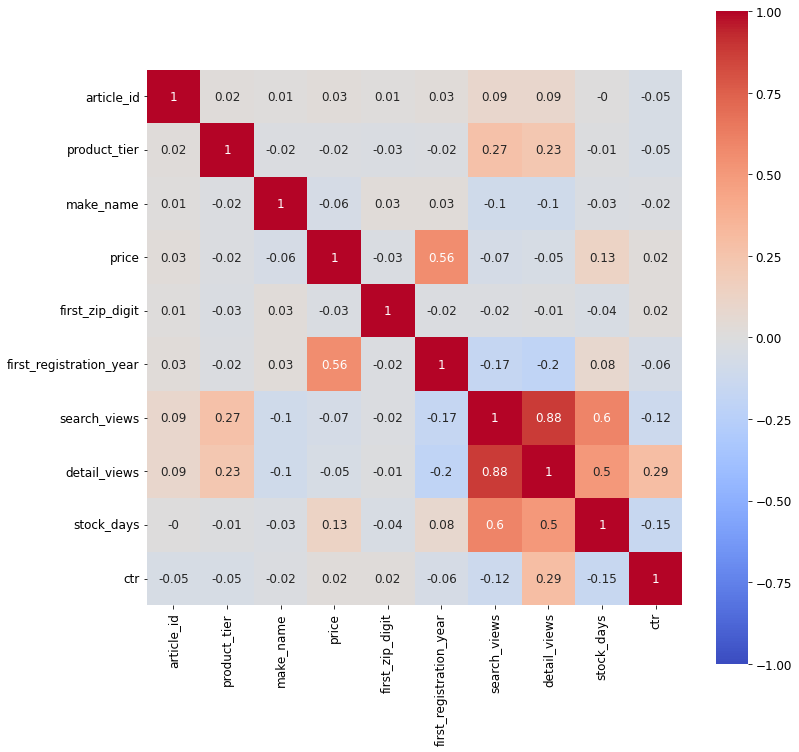

In [ ]:
# features with log-transformation
c = np.round(df_log.corr(), 2)
plt.figure(figsize=(12,12))
sns.heatmap(c, annot=True, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.rcParams.update({'font.size':12})

The heatmap of dataframe with logaritmic transformation shows strong moderate correlation of target value with features stock_days and weekend_no with 0.50. There is weak linear correlation of 0.24 to peak season. Compared to the heatmap with original (non-log tranformation) data, these correlations are higher here. Also, there is a moderate strong correlation with ctr, but ctr is calculated from the target value detail_views, and therefore should not be used as a feature.

Since we want to predict detail views, the feature "ctr" should be removed from the input features because it is computed from the detail views we want to predict, so it will bias our model. I assume here that the feature search_views is available at the time of prediction and therefore can be used as a predictor.

In [ ]:
X = df.loc[:, ['product_tier', 'make_name', 'price', 'first_zip_digit', 'first_registration_year', 'search_views', 'stock_days', 'peak_season']]
y = df['detail_views'].to_numpy()

In [ ]:
#split data into X and y from dataframe with log transformation
X = df_log.loc[:, ['product_tier', 'make_name', 'price', 'first_zip_digit', 'first_registration_year', 'search_views', 'stock_days' 'peak_season']]
y = df_log['detail_views'].to_numpy()

In [ ]:
# storing column names in features
features = X.columns

In [ ]:
X.head()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,stock_days,peak_season
0,0,62,4.224041,5,3.304059,3.490239,30,0.0
1,0,60,4.555711,4,3.304491,3.516403,52,1.0
2,0,60,4.077404,3,3.300813,3.511616,51,1.0
3,0,33,3.243286,6,3.301898,3.268812,101,1.0
4,0,60,4.423262,3,3.304275,2.691081,12,1.0


In [ ]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

## **Model Building, Training and Evaluation**

In [ ]:
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, train_sizes, cv, scoring): 
  train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, train_sizes = train_sizes, cv = cv, scoring = scoring)
  train_scores_mean = train_scores.mean(axis = 1)
  validation_scores_mean = validation_scores.mean(axis = 1)
  
  plt.plot(train_sizes, train_scores_mean, label = 'Training error')
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
  plt.ylabel('Explained variance', fontsize = 14)
  plt.xlabel('Training set size', fontsize = 14)
  title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
  plt.title(title, fontsize = 18, y = 1.03)
  plt.legend() 
  plt.rcParams.update({'font.size': 14})
#  plt.ylim(0,1.2)

### **Linear regression**

Building the first model with original (no-log transform) data

In [ ]:
from sklearn.linear_model import LinearRegression

# define model
lr_reg = make_pipeline(StandardScaler(), LinearRegression())
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(lr_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.712
Mean absolute error: 44.774
Root mean squared error: 122.321
R2: 0.712


In [ ]:
index = []
scores = {"MAE": [], "RMSE": [], "R2": []}

In [ ]:
index += ['Linear regression']
scores["MAE"].append(-cv_result['test_neg_mean_absolute_error'].mean())
scores["RMSE"].append(-cv_result['test_neg_root_mean_squared_error'].mean())
scores["R2"].append(cv_result['test_r2'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,MAE,RMSE,R2
Linear regression,44.773558,122.321086,0.711893


Building the model with log transformed data

In [ ]:
# define model
lr_reg = make_pipeline(StandardScaler(), LinearRegression())
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(lr_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.787
Mean absolute error: 0.221
Root mean squared error: 0.287
R2: 0.787


It can be seen that the higher accuracy is achieved when skewed features are transformed with log transformation. This transformation led to better learning from training data and better prediction on validation data.

In [ ]:
index = ["Logistic regression log"]
scores["MAE"]=-cv_result['test_neg_mean_absolute_error'].mean()
scores["RMSE"]=-cv_result['test_neg_root_mean_squared_error'].mean()
scores["R2"]=cv_result['test_r2'].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

,MAE,RMSE,R2
Linear regression,44.773558,122.321086,0.711893
Logistic regression log,0.220589,0.286600,0.787079


Based on the results above, I will use data with log transformation to train and evaluate other learning algorithms.

### **Support Vector Regression (SVR)**

Let's try with Support vector regression that find the best fit line in a form of the hyperplane that has the maximum number of points, i.e. which maximizes a specified margin, representing a tolerable error (epsilon).

In [ ]:
from sklearn.svm import SVR
# define model
svm_reg = make_pipeline(StandardScaler(), SVR(kernel='rbf', epsilon=0.1))
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(svm_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.807
Mean absolute error: 0.209
Root mean squared error: 0.273
R2: 0.806


In [ ]:
index = ["SVR log"]
scores["MAE"]=-cv_result['test_neg_mean_absolute_error'].mean()
scores["RMSE"]=-cv_result['test_neg_root_mean_squared_error'].mean()
scores["R2"]=cv_result['test_r2'].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

,MAE,RMSE,R2
Linear regression,44.773558,122.321086,0.711893
Logistic regression log,0.220589,0.286600,0.787079
SVR log,0.209321,0.273441,0.806174


SVR model with log transformed data provides lower MAE and RMSE, while increasing R2 by 0.02.

### **eXtreme Gradient Boosting (XGBoost)**

Let's now try XGB - boosted decision trees for predicting detail_views as it is a highly effective and widely used method. It has proven to be one of the best algorithms for structured problems that use tabular datasets with numbers and categories. It is very fast to train and easy to optimize.

In [ ]:
import xgboost as xgb
# define model
xgb_reg = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective='reg:squarederror', 
                                                           max_depth=5, learning_rates=0.1, 
                                                           n_estimators=100))
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(xgb_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.809
Mean absolute error: 0.209
Root mean squared error: 0.271
R2: 0.809


In [ ]:
index = ["XGB log"]
scores["MAE"]=-cv_result['test_neg_mean_absolute_error'].mean()
scores["RMSE"]=-cv_result['test_neg_root_mean_squared_error'].mean()
scores["R2"]=cv_result['test_r2'].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

,MAE,RMSE,R2
Linear regression,44.773558,122.321086,0.711893
Logistic regression log,0.220589,0.286600,0.787079
SVR log,0.209321,0.273441,0.806174
XGB log,0.208644,0.271273,0.809238


The results from XGB are slightly improved w.r.t SVR results. So here we see that their accuracy performance is simmilar on this task, but from the computational efficiency SVR took much more time to train than XGB.

### **Multi-Layer Perceptron (MLP)**

Let's also try a simple artificial neural network algorithm: MLP (Multi Layer Perceptron). I chose MLP because we have a limited data set and the problem is not so complex that it requires deep learning. Deep neural networks require large datasets so as not to overfit the data, and are best suited for unstructured problems, such as images, videos, sound, text.

I will try MLP networks with 3 different sizes: one hidden layer with 100, 500 and 1000 neurons.

In [ ]:
from sklearn.neural_network import MLPRegressor
# define model
mlp_reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='sgd', 
                                                       alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001,))
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(mlp_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.799
Mean absolute error: 0.215
Root mean squared error: 0.278
R2: 0.799


In [ ]:
from sklearn.neural_network import MLPRegressor
# define model
mlp_reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(500,), activation='relu', solver='sgd', 
                                                       alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001,))
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(mlp_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.802
Mean absolute error: 0.212
Root mean squared error: 0.276
R2: 0.802


In [ ]:
from sklearn.neural_network import MLPRegressor
# define model
mlp_reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(1000,), activation='relu', solver='sgd', 
                                                       alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001,))
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(mlp_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.803
Mean absolute error: 0.212
Root mean squared error: 0.276
R2: 0.803


Increasing the number of neurons resulted in a slight improvement in accuracy. The third model with 1000 neurons in the hidden layer had the best results among the other ANNs and is included in the final table of the algorithm comparison.

In [ ]:
index = ["MLP log"]
scores["MAE"]=-cv_result['test_neg_mean_absolute_error'].mean()
scores["RMSE"]=-cv_result['test_neg_root_mean_squared_error'].mean()
scores["R2"]=cv_result['test_r2'].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

,MAE,RMSE,R2
Linear regression,44.773558,122.321086,0.711893
Logistic regression log,0.220589,0.286600,0.787079
SVR log,0.209321,0.273441,0.806174
XGB log,0.208644,0.271273,0.809238
MLP log,0.212057,0.275718,0.802929


The results show that the MLP model has lower accuracy than the SVR and XGB for this problem. Since the XGBoost (XGB) model has the highest accuracy, it is fine-tuned in the next step to further improve the accuracy.

### **XGBoost fine-tuning**

In [ ]:
#parameters tuning
max_depth = [3, 5, 8, 10, 15, 20]

for count in max_depth:
  cv_result = cross_validate(xgb.XGBRegressor(objective='reg:squarederror', max_depth=count, learning_rate=0.1, n_estimators=100), X_train, y_train, cv=5, scoring=scoring)
  print(f'For max depth: {count}')
  print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
  print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
  print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")

For max depth: 3
Explained variance: 0.806
Mean absolute error: 0.211
Root mean squared error: 0.273
For max depth: 5
Explained variance: 0.809
Mean absolute error: 0.209
Root mean squared error: 0.271
For max depth: 8
Explained variance: 0.809
Mean absolute error: 0.209
Root mean squared error: 0.272
For max depth: 10
Explained variance: 0.805
Mean absolute error: 0.211
Root mean squared error: 0.274
For max depth: 15
Explained variance: 0.790
Mean absolute error: 0.219
Root mean squared error: 0.285
For max depth: 20
Explained variance: 0.782
Mean absolute error: 0.223
Root mean squared error: 0.290


In [ ]:
estimators = [50, 100, 150, 200, 300, 400, 500]

for count in estimators:
  cv_result = cross_validate(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=count, max_depth=5, learning_rate=0.1), X_train, y_train, cv=5, scoring=scoring)
  print(f'For estimators: {count}')
  print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
  print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
  print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")

For estimators: 50
Explained variance: 0.807
Mean absolute error: 0.210
Root mean squared error: 0.273
For estimators: 100
Explained variance: 0.809
Mean absolute error: 0.209
Root mean squared error: 0.271
For estimators: 150
Explained variance: 0.810
Mean absolute error: 0.208
Root mean squared error: 0.271
For estimators: 200
Explained variance: 0.810
Mean absolute error: 0.208
Root mean squared error: 0.270
For estimators: 300
Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270
For estimators: 400
Explained variance: 0.810
Mean absolute error: 0.208
Root mean squared error: 0.271
For estimators: 500
Explained variance: 0.810
Mean absolute error: 0.208
Root mean squared error: 0.271


In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5]

for count in learning_rates:
  cv_result = cross_validate(xgb.XGBRegressor(objective='reg:squarederror', learning_rates=count, n_estimators=300, max_depth=5), X_train, y_train, cv=5, scoring=scoring)
  print(f'For learning rates: {count}')
  print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
  print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
  print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")

For learning rates: 0.01
Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270
For learning rates: 0.05
Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270
For learning rates: 0.1
Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270
For learning rates: 0.3
Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270
For learning rates: 0.5
Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270


In [ ]:
# define model
xgb_reg = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective='reg:squarederror', 
                                                           max_depth=5, learning_rate=0.1, 
                                                           n_estimators=300))
# define scoring
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
# evaluate model
cv_result = cross_validate(xgb_reg, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Explained variance: {cv_result['test_explained_variance'].mean():.3f}")
print(f"Mean absolute error: {-cv_result['test_neg_mean_absolute_error'].mean():.3f}")
print(f"Root mean squared error: {-cv_result['test_neg_root_mean_squared_error'].mean():.3f}")
print(f"R2: {cv_result['test_r2'].mean():.3f}")

Explained variance: 0.811
Mean absolute error: 0.208
Root mean squared error: 0.270
R2: 0.811


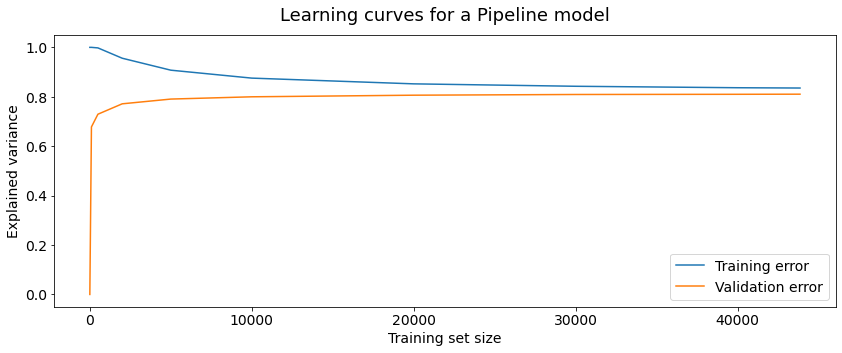

In [ ]:
plt.figure(figsize = (14,5))
train_sizes = [1, 100, 500, 2000, 5000, 10000, 20000, 30000, 40000, 43845]
learning_curves(xgb_reg, X_train, y_train, train_sizes, 5, 'explained_variance')

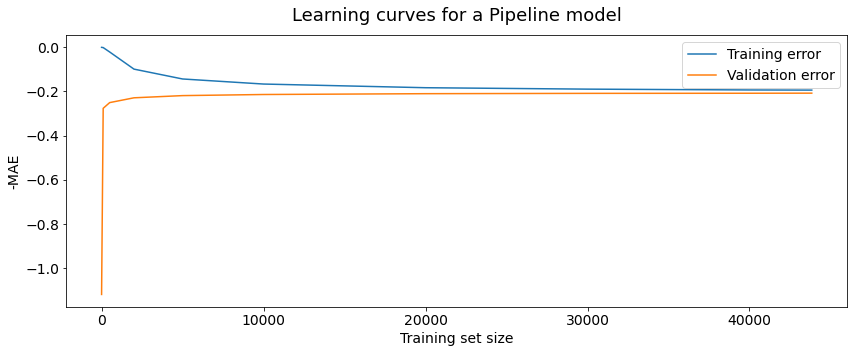

In [ ]:
plt.figure(figsize = (14,5))
train_sizes = [1, 100, 500, 2000, 5000, 10000, 20000, 30000, 40000, 43845]
learning_curves(xgb_reg, X_train, y_train, train_sizes, 5, 'neg_mean_absolute_error')

The learning curves show that the accuracy on the validation data improves as the size of the training set increases. In the end, the validation error is similar to the training error.

In [ ]:
index = ["XGB tuned log"]
scores["MAE"]=-cv_result['test_neg_mean_absolute_error'].mean()
scores["RMSE"]=-cv_result['test_neg_root_mean_squared_error'].mean()
scores["R2"]=cv_result['test_r2'].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

,MAE,RMSE,R2
Linear regression,44.773558,122.321086,0.711893
Logistic regression log,0.220589,0.286600,0.787079
SVR log,0.209321,0.273441,0.806174
XGB log,0.208644,0.271273,0.809238
MLP log,0.212057,0.275718,0.802929
XGB tuned log,0.207829,0.270373,0.810500


XGB tuned model delivers the best performance metric results.

### **Final Model Evaluation**

Final evaluation of the model "XGB tuned log" on test dataset.

In [ ]:
xgb_reg=xgb_reg.fit(X_train, y_train)
# predict 
y_pred = xgb_reg.predict(X_test)
# metrics
from sklearn.metrics import r2_score
print(f"Explained variance: {explained_variance_score(y_true=y_test, y_pred=y_pred):.3f}")
print(f"R2 score: {r2_score(y_true=y_test, y_pred=y_pred):.3f}")
print(f"Mean absolute error: {mean_absolute_error(y_true=y_test, y_pred=y_pred):.3f}")
print(f"Root mean squared error: {np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)):.3f}")

Explained variance: 0.807
R2 score: 0.807
Mean absolute error: 0.207
Root mean squared error: 0.271


Result on test dataset are similar as on cross-validation dataset, showing that the model is able to generalize well to new examples.

In [ ]:
y_pred_transf=10**(y_pred)
y_test_transf=10**(y_test)

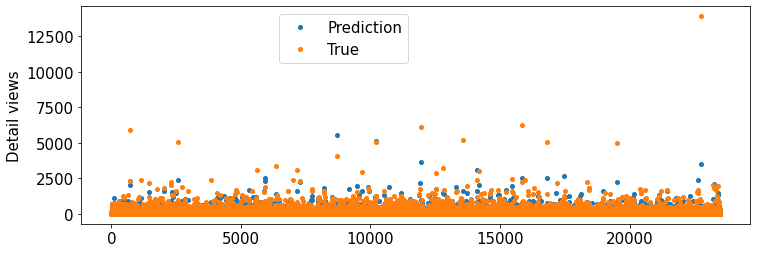

In [ ]:
fig, axs = plt.subplots(1)
plt.plot(y_pred_transf, 'o', linewidth=1, markersize=4,  label='Prediction')
plt.plot(y_test_transf,  'o', linewidth=1,markersize=4, label='True')
#plt.yticks((np.arange(0.0, 31.0, 10.0)))
plt.legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
axs.set(ylabel='Detail views')
plt.rcParams ['figure.figsize'] = [12, 4]
plt.show()
plt.rcParams.update({'font.size': 15})

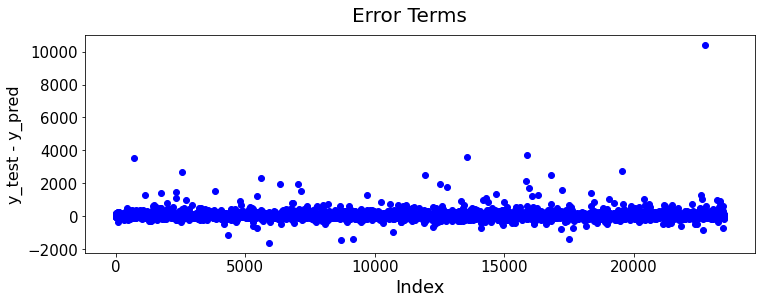

In [ ]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c, y_test_transf-y_pred_transf, 'o', color="blue")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('y_test - y_pred', fontsize=16)                # Y-label
plt.show()

From the results, it appears that the model did not correctly predict all higher values, i.e., outliers.

Plotting the error terms to understand the distribution

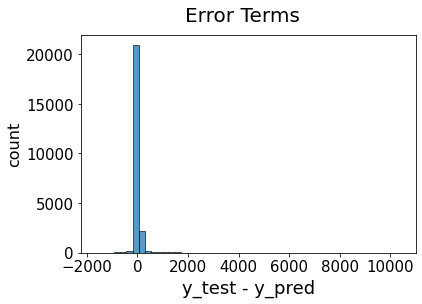

In [ ]:
fig = plt.figure()
sns.histplot((y_test_transf-y_pred_transf),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test - y_pred', fontsize=18)                  # X-label
plt.ylabel('count', fontsize=16)                          # Y-label
plt.show()
plt.rcParams ['figure.figsize'] = [6, 4]

From the distribution it can be seen that most of the errors are at 0. The higher errors are in the minority and they are mostly positive, which means that the model underestimates some outliers.

In [ ]:
# Permutation feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(xgb_reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
xgb_importances = pd.Series(result.importances_mean, index=features)

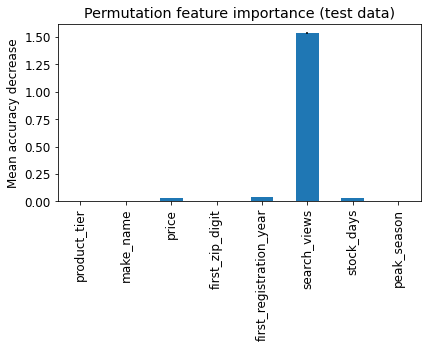

In [ ]:
#Permutation feature importance on test dataset
fig, ax = plt.subplots()
xgb_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Permutation feature importance (test data)")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.rcParams.update({'font.size': 12})
plt.show()
plt.rcParams ['figure.figsize'] = [6, 5]

In [ ]:
#printing values for feature importances
for i,v in enumerate(xgb_importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00084
Feature: 1, Score: 0.00675
Feature: 2, Score: 0.03349
Feature: 3, Score: 0.00139
Feature: 4, Score: 0.03612
Feature: 5, Score: 1.53373
Feature: 6, Score: 0.03328
Feature: 7, Score: 0.00111


Based on feature importance, it can be seen that the most important feature is search_views, while the other important features are stock_days, first_registration_year and price.

### Conclusion

*   It is possible to predict detail_views with very good accuracy, when search_views is used as input feature. The results show that feature search_views is dominantly contributing to the model predictions.
*   Results show that the majority of errors are around zero and that model underestimates outliers, i.e. predict mostly lower values for extreme cases.
*   Transforming skewed data with log transformation efficiently improves accuracy of the model predictions.



